# Genre Classification using Supervised Machine Learning Models

In [ ]:
# Installing shap

!pip install shap

In [ ]:
# Importing modules

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

import shap
import joblib
from tqdm import tqdm

In [ ]:
# Mount GDrive folders
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set home directory
import os
home_dir = "drive/MyDrive/Eskwelabs"
os.chdir(home_dir)

## 1. Read and check values of playlist sets

### 1.1. Set genres for prediction

In [ ]:
genre_names = ['R&B', 'Electronic', 'Jazz', 'Rap', 'Rock']

### 1.2. Read and check tracks data for each genre

Collect genre playlist data

In [ ]:
playlist_df_list = []
for genre in tqdm(genre_names):
    pdf = pd.read_csv('data/playlists/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower()
    playlist_df_list.append(pdf)

100%|██████████| 5/5 [00:00<00:00, 40.51it/s]


Collect genre track data

In [ ]:
track_df_list = []
for genre in tqdm(genre_names):
    tdf = pd.read_csv('data/playlists/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf = tdf[~tdf.duplicated(subset=['track_id'])]
    tdf['genre'] =  genre.lower()
    track_df_list.append(tdf)

100%|██████████| 5/5 [00:00<00:00, 19.69it/s]


Concatenate playlist data

In [ ]:
playlist_df = pd.concat(playlist_df_list)
playlist_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3759509,r&b
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2762610,r&b
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2188378,r&b
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,1175872,r&b
4,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,50,spotify,Spotify,883491,r&b


In [ ]:
playlist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 96
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   playlist_id            428 non-null    object
 1   playlist_name          428 non-null    object
 2   playlist_total_tracks  428 non-null    int64 
 3   owner_id               428 non-null    object
 4   owner_name             428 non-null    object
 5   total_followers        428 non-null    int64 
 6   genre                  428 non-null    object
dtypes: int64(2), object(5)
memory usage: 26.8+ KB


Get genre playlist tally

In [ ]:
playlist_df['genre'].value_counts()

jazz          100
rock           97
rap            92
electronic     71
r&b            68
Name: genre, dtype: int64

Concatenate playlist data

In [ ]:
tracks_df = pd.concat(track_df_list)
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre
0,2c7huQpWR29bcXrrvLcG2j,We Need A Resolution (feat. Timbaland),0urTpYCsixqZwgNTkPJOJ4,Aaliyah,0cNaDPtbHC1PMJMRTY2GFc,242826,2001-07-07,64,0.728,0.512,...,0,0.2900,0.3000,0.000000,0.113,0.824,147.170,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b
1,0ceeRNqbOzRiGE42KWSrRa,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,43QuYbSfbTjcsghwJyUnyP,294093,2004-04-05,61,0.677,0.531,...,0,0.0327,0.2190,0.000000,0.173,0.570,91.104,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b
2,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,71,0.569,0.596,...,1,0.1720,0.4520,0.000079,0.205,0.754,93.135,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b
4,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0,0.2150,0.1970,0.000000,0.209,0.781,94.967,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b
5,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,60,0.608,0.760,...,0,0.2420,0.0129,0.000000,0.332,0.366,168.211,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b


In [ ]:
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8613 entries, 0 to 2130
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          8613 non-null   object 
 1   track_name        8613 non-null   object 
 2   artist_id         8613 non-null   object 
 3   artist_name       8613 non-null   object 
 4   album_id          8613 non-null   object 
 5   duration          8613 non-null   int64  
 6   release_date      8613 non-null   object 
 7   popularity        8613 non-null   int64  
 8   danceability      8613 non-null   float64
 9   energy            8613 non-null   float64
 10  key               8613 non-null   int64  
 11  loudness          8613 non-null   float64
 12  mode              8613 non-null   int64  
 13  speechiness       8613 non-null   float64
 14  acousticness      8613 non-null   float64
 15  instrumentalness  8613 non-null   float64
 16  liveness          8613 non-null   float64


Get genre tracks tally

In [ ]:
tracks_df['genre'].value_counts()

jazz          2342
rock          1877
electronic    1874
rap           1342
r&b           1178
Name: genre, dtype: int64

## 2. Refine the training data

**Refinement 1**

Get only *top 10 most followed playlists* per genre.

>Q: Try out keeping top 15 most followed playlists and see what results youll get.

In [ ]:
#.head() will show top 10 followed playlists
# since playlists csv is already ordered by decreasing total followers
top_playlists_df = playlist_df.groupby(['genre']).head(15)
top_playlists_df

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3759509,r&b
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2762610,r&b
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2188378,r&b
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,1175872,r&b
4,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,50,spotify,Spotify,883491,r&b
...,...,...,...,...,...,...,...
10,37i9dQZF1DWUoqEG4WY6ce,Indie Rock Road Trip,89,spotify,Spotify,762777,rock
11,37i9dQZF1DX30HHrCAl4ZG,Today's Indie Rock,100,spotify,Spotify,748474,rock
12,37i9dQZF1DX4vth7idTQch,Rockhymnen,100,spotify,Spotify,594327,rock
13,37i9dQZF1DWXs1L3AC0Xio,Rock Ballads,100,spotify,Spotify,587078,rock


In [ ]:
# Filter keeping only top 10 playlists
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]

In [ ]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

jazz          1719
rock          1566
electronic    1506
rap           1087
r&b            855
Name: genre, dtype: int64

**Refinement 2**

Remove tracks that appear in different genre playlists - get only *unique tracks* per genre

In [ ]:
# View duplicated
# Use artist id and track name to ensure uniqueness
tracks_df[tracks_df.duplicated(subset=['artist_id','track_name'])]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre
319,4AIiCP2scA6jt6jAKfkvTX,fue mejor (feat. SZA),1U1el3k54VvEUzo3ybLPlM,Kali Uchis,64SrjXrYNfYvQcccFmYEHu,230964,2020-12-04,66,0.769,0.384,...,0,0.0353,0.23900,0.000227,0.0762,0.230,106.002,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,r&b
323,7GaFYUqP2WdR4KTPk7cXoP,Let Me Love You,20s0P9QLxGqKuCsGwFsp7w,Mario,0aihmuRLi1gBkxk4mbNfcv,249120,2004-03-15,69,0.686,0.588,...,0,0.0554,0.17800,0.000000,0.0954,0.617,94.519,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,r&b
339,1DNA2z7Txysjk3cNz2nDLm,WFM,35R1B97CfrqKFFI3QBkTDx,RealestK,0bhFNhb3j8MRYLFXvnIXGp,136000,2021-10-06,82,0.437,0.184,...,1,0.0313,0.72000,0.002530,0.1130,0.247,80.088,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,r&b
344,6IwKcFdiRQZOWeYNhUiWIv,No One,3DiDSECUqqY1AuBP8qtaIa,Alicia Keys,6KlxyxhXEDo1LdheFulN7h,253813,2007-11-09,79,0.644,0.549,...,0,0.0285,0.02090,0.000009,0.1340,0.167,90.040,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,r&b
374,0bkTdkWwGk3OGFX0afD3Wj,Mystery Lady,3ycxRkcZ67ALN3GQJ57Vig,Masego,1S0yIZRDiFmqCQyTIEV175,228453,2020-11-13,68,0.747,0.494,...,0,0.1410,0.39300,0.000000,0.0982,0.624,76.006,37i9dQZF1EQoqCH7BwIYb7,R&B Mix,r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1618,2udGjDmpK1dH9VGyw7nrei,Cocaine,6PAt558ZEZl0DmdXlnjMgD,Eric Clapton,0GBrlPh90D25SQ6EJu4VtT,221640,1977-11-01,71,0.699,0.502,...,1,0.0278,0.06070,0.033700,0.3170,0.676,105.267,37i9dQZF1DX4vth7idTQch,Rockhymnen,rock
1621,0MKGH8UMfCnq5w7nG06oM5,Come As You Are,6olE6TJLqED3rqDCT0FyPh,Nirvana,2uEf3r9i2bnxwJQsxQ0xQ7,218920,1991-09-26,64,0.500,0.824,...,0,0.0388,0.00016,0.001610,0.0916,0.539,120.125,37i9dQZF1DX4vth7idTQch,Rockhymnen,rock
1628,1Cj2vqUwlJVG27gJrun92y,The Sound of Silence,3TOqt5oJwL9BE2NG9MEwDa,Disturbed,3qFQ4XNQ15alZrAaj5oGJK,248466,2015-08-21,73,0.322,0.280,...,0,0.0281,0.46800,0.000001,0.1020,0.175,85.794,37i9dQZF1DWXs1L3AC0Xio,Rock Ballads,rock
1636,6GrrkiCRO3HYdgRpO4eKEL,Swing Life Away,6Wr3hh341P84m3EI8qdn9O,Rise Against,1vHYkIhnwbpzrC3hGguDN6,200066,2004-01-01,59,0.477,0.426,...,1,0.0430,0.54400,0.000000,0.0903,0.789,184.866,37i9dQZF1DWXs1L3AC0Xio,Rock Ballads,rock


In [ ]:
# Filter non-uniquely listed tracks
tracks_df = tracks_df.drop_duplicates(subset=['artist_id','track_name'])
tracks_df.shape

(6563, 22)

In [ ]:
# Get new genre tracks tally
tracks_df['genre'].value_counts()

jazz          1704
electronic    1492
rock          1482
rap           1070
r&b            815
Name: genre, dtype: int64

## 3. Feature Engineering

**Categorical Encoding**
Since supervised models only takes in integers as labels, we map genres to numbers

In [ ]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id
0,2c7huQpWR29bcXrrvLcG2j,We Need A Resolution (feat. Timbaland),0urTpYCsixqZwgNTkPJOJ4,Aaliyah,0cNaDPtbHC1PMJMRTY2GFc,242826,2001-07-07,64,0.728,0.512,...,0.2900,0.3000,0.000000,0.113,0.824,147.170,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2
1,0ceeRNqbOzRiGE42KWSrRa,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,43QuYbSfbTjcsghwJyUnyP,294093,2004-04-05,61,0.677,0.531,...,0.0327,0.2190,0.000000,0.173,0.570,91.104,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2
2,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,71,0.569,0.596,...,0.1720,0.4520,0.000079,0.205,0.754,93.135,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2
4,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0.2150,0.1970,0.000000,0.209,0.781,94.967,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2
5,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,60,0.608,0.760,...,0.2420,0.0129,0.000000,0.332,0.366,168.211,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2


Build dictionary of label ids for later

In [ ]:
genre_lookup = tracks_df[['genre_id','genre']].drop_duplicates()\
                        .sort_values('genre_id')\
                        .set_index('genre_id')\
                        .to_dict()['genre']
genre_lookup

{0: 'electronic', 1: 'jazz', 2: 'r&b', 3: 'rap', 4: 'rock'}

Select audio features to use for the model

In [ ]:
# create feature matrix (X)
# pick energy and tempo as features
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
print(len(X),len(y))

6563 6563


Add to matrices

In [ ]:
X = tracks_df[feature_cols]
y = tracks_df['genre_id']

Split to train and test set

In [ ]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 4. Train Models

### 4.1. k-Nearest Neighbors (kNN)

Perform KNN using `K = [2, 50]` and validate using k-fold cross validation `k = 5`

In [ ]:
# Set parameter values
n_neighbors = np.arange(2,51)
k = 5 # for kfold

In [ ]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = KNeighborsClassifier()

# Initialize cross validation
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize pipeline
pipeline = Pipeline([("scaler", scaler),("knn", model)])

Initialize parameter grid

In [ ]:
# Initialize parameters
param_grid = {'knn__n_neighbors': n_neighbors}

Find optimal parameters

In [ ]:
model_grid_search = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             verbose=1)

In [ ]:
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             verbose=1)

Get best params and scores

In [ ]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'knn__n_neighbors': 44}
Train best score: 0.687048
Train best score std: 0.0117132


View test score

In [ ]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.682407


Select best KNN model

In [ ]:
knn_model_pipeline = model_grid_search.best_estimator_
knn_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=44))])

### 4.2. Random Forest (RF)

Perform Random Forest and validate using k-fold cross validation k = 5

In [ ]:
# Set parameter values
k = 5 # for kfold

In [ ]:
# Set scaler
scaler = MinMaxScaler()   # RobustScaler would also work

# Initialize model
model = RandomForestClassifier()

# Initialize pipeline
pipeline = Pipeline ([("scaler", scaler),("rfc", model)])

# Initialize cross validation
cv = KFold(n_splits=k, shuffle=True, random_state=42)

Initialize parameter grid

In [ ]:
param_grid = {
    'rfc__n_estimators': [50, 100, 200, 500],
    'rfc__max_depth' : [None, 5, 10, 15, 20],
}

Find optimal parameters

In [ ]:
model_grid_search = GridSearchCV(pipeline, param_grid, verbose = 1, cv = cv)
model_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'rfc__max_depth': [None, 5, 10, 15, 20],
                         'rfc__n_estimators': [50, 100, 200, 500]},
             verbose=1)

Get best params and scores

In [ ]:
print(f"Best hyperparameters: {model_grid_search.best_params_}")
print(f"Train best score: {model_grid_search.best_score_:0.6}")
print(f"Train best score std: {np.std(model_grid_search.cv_results_['mean_test_score']):0.6}")

Best hyperparameters: {'rfc__max_depth': None, 'rfc__n_estimators': 500}
Train best score: 0.745905
Train best score std: 0.0191


View test score

In [ ]:
test_score = model_grid_search.score(X_test, y_test)
print(f"Test best score: {test_score:0.6}")

Test best score: 0.737243


Visualize final tree

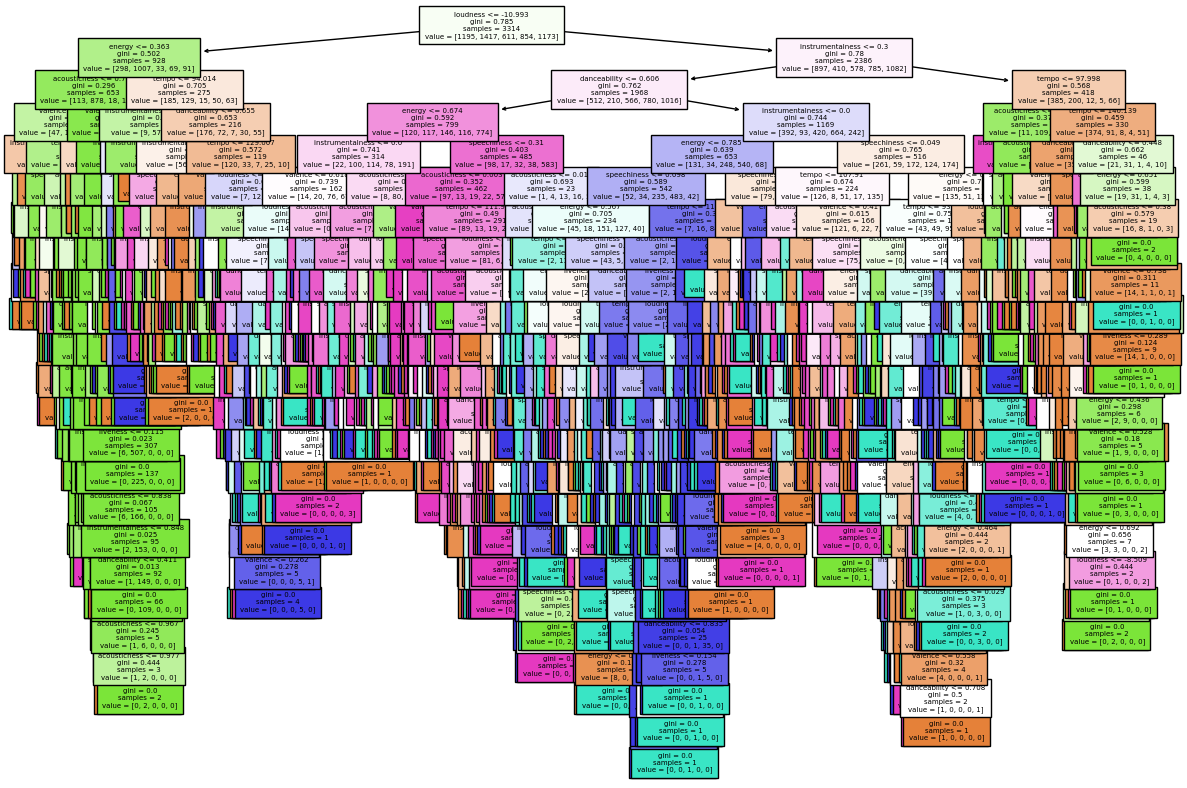

In [ ]:
best_params = {k.split('__')[1]:v for k,v in model_grid_search.best_params_.items()}
rfc_best = RandomForestClassifier(random_state=42, **best_params)
rfc_best.fit(X_train, y_train)

# plot
plt.figure(figsize=(12,8))
plot_tree(rfc_best.estimators_[0],feature_names=X_train.columns, filled=True, fontsize=5)
plt.tight_layout()


Select best RF model

In [ ]:
rfc_model_pipeline = model_grid_search.best_estimator_
rfc_model_pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('rfc', RandomForestClassifier(n_estimators=500))])

## 5. Select Best Model

Generate genre predictions per best model

In [ ]:
knn_y_pred = knn_model_pipeline.fit(X_train, y_train).predict(X_test)
# svc_y_pred = svc_model_pipeline.fit(X_train, y_train).predict(X_test)
rfc_y_pred = rfc_model_pipeline.fit(X_train, y_train).predict(X_test)

Generate classification report per best model

In [ ]:
model_names = ['KNN','RF']
for i,y_pred in enumerate([knn_y_pred, rfc_y_pred]):
    print('-------------------------------------------------------------')
    print(model_names[i])
    print(classification_report(y_test,y_pred,\
                                target_names=genre_lookup.values()))

-------------------------------------------------------------
KNN
              precision    recall  f1-score   support

  electronic       0.68      0.72      0.70       274
        jazz       0.82      0.81      0.81       354
         r&b       0.47      0.33      0.39       187
         rap       0.59      0.67      0.63       203
        rock       0.68      0.73      0.70       295

    accuracy                           0.68      1313
   macro avg       0.65      0.65      0.65      1313
weighted avg       0.68      0.68      0.68      1313

-------------------------------------------------------------
RF
              precision    recall  f1-score   support

  electronic       0.79      0.76      0.77       274
        jazz       0.85      0.84      0.84       354
         r&b       0.54      0.45      0.49       187
         rap       0.62      0.69      0.65       203
        rock       0.75      0.81      0.78       295

    accuracy                           0.74      1313


- accuracy = % correct genre classifications
        all correct / all
- precision =  % correct genre classifications given everything model classified as that genre, emphasizes false positives
        TP/TP+FP
- recall = % correct genre classifications given all actual tracks in the genre, emphasizes false negatives
        TP/TP+FN
- f1-score = weighted average of Precision and Recall
        F1 Score = 2*(Recall * Precision) / (Recall + Precision)
- support = number of items in the class

- macro ave = average of the unweighted mean per label
- weighted ave = average of the weighted mean per label


Plot confusion matrices

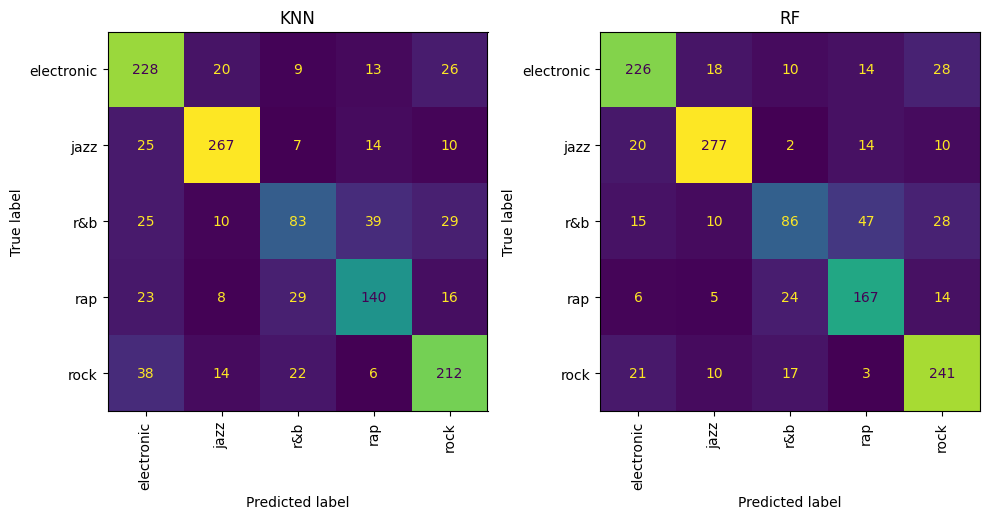

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
model_names = ['KNN','RF']
for i,y_pred in enumerate([knn_y_pred, rfc_y_pred]):
    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=list(genre_lookup.values()))
    cmd.plot(ax=axs[i], xticks_rotation=90, colorbar=False)
    axs[i].set_title(model_names[i])
plt.tight_layout()


Store best model

In [ ]:
best_model_pipeline = rfc_model_pipeline

In [ ]:
best_model = best_model_pipeline.named_steps['rfc']
best_model_scaler = best_model_pipeline.named_steps['scaler']

Add predictions as columns to `tracks_df`

In [ ]:
tracks_df['predicted_genre_id'] = best_model_pipeline.predict(tracks_df[feature_cols])
tracks_df['predicted_genre'] = tracks_df['predicted_genre_id'].map(genre_lookup)
tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name,genre,genre_id,predicted_genre_id,predicted_genre
0,2c7huQpWR29bcXrrvLcG2j,We Need A Resolution (feat. Timbaland),0urTpYCsixqZwgNTkPJOJ4,Aaliyah,0cNaDPtbHC1PMJMRTY2GFc,242826,2001-07-07,64,0.728,0.512,...,0.000000,0.113,0.824,147.170,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2,2,r&b
1,0ceeRNqbOzRiGE42KWSrRa,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,43QuYbSfbTjcsghwJyUnyP,294093,2004-04-05,61,0.677,0.531,...,0.000000,0.173,0.570,91.104,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2,2,r&b
2,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,71,0.569,0.596,...,0.000079,0.205,0.754,93.135,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2,2,r&b
4,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0.000000,0.209,0.781,94.967,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2,2,r&b
5,6nTcn8CybBcx0t7IaXEJ6O,Thank God I Found You (feat. Joe & Nas) - Make...,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,6zuCJaxmHKNKN5hMDF556U,251640,2000-04-18,60,0.608,0.760,...,0.000000,0.332,0.366,168.211,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,r&b,2,2,r&b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,7lSDCrF11sdTVfjbAQVZE8,I Fought the Law,3RGLhK1IP9jnYFH4BRFJBS,The Clash,3Zkggi5I9uH5x94DuN6u1S,163240,2013-08-26,63,0.526,0.900,...,0.000041,0.140,0.883,151.279,37i9dQZF1DX2S9rTKTX6JP,Rock Covers,rock,4,4,rock
1816,7umzok5rx1Lctwa2pb03OR,When Doves Cry,4v9rMwiF0d2Fh7bStHloi1,Everyone Loves A Villain,302wtl4vr5C1SsCTfBFMsJ,196938,2020-02-14,39,0.531,0.898,...,0.000198,0.335,0.490,117.005,37i9dQZF1DX2S9rTKTX6JP,Rock Covers,rock,4,4,rock
1817,5pNRCnwwQZmluol3V1pR6e,Losing My Religion,1kkyfIopIiVvaPHHlbsfac,Movements,5XkUTL5Ccl5krryba7M7JI,269946,2018-11-09,0,0.548,0.898,...,0.000021,0.298,0.704,127.994,37i9dQZF1DX2S9rTKTX6JP,Rock Covers,rock,4,4,rock
1818,4s7Nan6D8QC02ORXGM0slB,That Thing You Do!,1MrEurzLcL8ugfP1PrUPWG,Billie Joe Armstrong,5Oa5fQh8Uv1GJQk7Wx3QoM,168600,2020-08-28,38,0.457,0.942,...,0.000000,0.153,0.595,134.998,37i9dQZF1DX2S9rTKTX6JP,Rock Covers,rock,4,4,rock


Use scaler from pipeline to transform

In [ ]:
features = best_model_scaler.transform(X_train)

Run SHAP explainer and get importance values

In [ ]:
explainer = shap.TreeExplainer(best_model,\
                            feature_names=feature_cols)
shap_values = explainer.shap_values(features)

In [ ]:
shap.summary_plot(shap_values=shap_values,
                  features = features,
                  feature_names = feature_cols,
                  class_names = list(genre_lookup.values()),
                  plot_type = "bar")

In [ ]:
# Get sample track and index, scale features
sample = tracks_df[tracks_df['track_name'].str.contains('Under Pressure')]
sample_idx = sample.index.values[0]
sample_features = best_model_scaler.transform(sample[feature_cols])
sample

In [ ]:
# Plot force plot per genre
shap_values = explainer.shap_values(sample_features)
shap.initjs()
for genre_id in range(8):
    print(genre_lookup[genre_id])
    display(shap.force_plot(explainer.expected_value[genre_id], shap_values[genre_id], sample_features,\
                             feature_names=feature_cols))


## Save the pipeline

In [ ]:
joblib.dump(best_model_pipeline,'genre_classifier_group4.pkl')

['genre_classifier_group4.pkl']